<a href="https://colab.research.google.com/github/jaehyun0220/DL/blob/master/Git_Temp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 데이터 활용에 필요한 기본 패키지 로딩
import sys #access to system parameters 
print("Python version: {}". format(sys.version))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import tensorflow as tf
print("tensorflow version: {}".format(tf.__version__))

import os
#import io

from google.colab import files

Python version: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
pandas version: 1.1.5
scikit-learn version: 0.22.2.post1
NumPy version: 1.19.5
tensorflow version: 2.4.1


In [3]:
# Auth 인증 및 Google Drive 활용 Data load
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# Google Drive 내 Custom Class 경로 지정
import sys
sys.path.insert(0, '/gdrive/My Drive/CustomClasses')

Mounted at /gdrive


In [4]:
!ls /gdrive/My\ Drive/data

bert		   df_all.gsheet	joongo.csv	       test.csv
chromedriver	   download		mj-clean.csv	       train.csv
crawl-300d-2M.vec  FashionMNIST		sample_submission.csv
df_all.csv	   glove.840B.300d.txt	Study


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
"""This file contains code for use with "Think Stats",
by Allen B. Downey, available from greenteapress.com
Copyright 2014 Allen B. Downey
License: GNU GPLv3 http://www.gnu.org/licenses/gpl.html
"""

from __future__ import print_function, division

import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as smtsa

import matplotlib.pyplot as pyplot

import thinkplot
import thinkstats2

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [39]:
FORMATS = ['png']

def ReadData():
    """Reads data about cannabis transactions.
    http://zmjones.com/static/data/mj-clean.csv
    returns: DataFrame
    """
    transactions = pd.read_csv('/gdrive/My Drive/data/mj-clean.csv', parse_dates=[5])
    return transactions


def tmean(series):
    """Computes a trimmed mean.
    series: Series 
    returns: float
    """
    t = series.values
    n = len(t)
    if n <= 3:
        return t.mean()
    trim = max(1, n//10)
    return np.mean(sorted(t)[trim:n-trim])


def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.
    transactions: DataFrame of transactions
    returns: DataFrame of daily prices
    """
    groups = transactions[['date', 'ppg']].groupby('date')
    daily = groups.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily


def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.
    transaction: DataFrame of transactions
    
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies


def PlotDailies(dailies):
    """Makes a plot with daily prices for different qualities.
    dailies: map from name to DataFrame
    """
    thinkplot.PrePlot(rows=3)
    for i, (name, daily) in enumerate(dailies.items()):
        thinkplot.SubPlot(i+1)
        title = 'price per gram ($)' if i == 0 else ''
        thinkplot.Config(ylim=[0, 20], title=title)
        thinkplot.Scatter(daily.ppg, s=10, label=name)
        if i == 2: 
            pyplot.xticks(rotation=30)
        else:
            thinkplot.Config(xticks=[])

    thinkplot.Save(root='timeseries1',
                   formats=FORMATS)


def RunLinearModel(daily):
    """Runs a linear model of prices versus years.
    daily: DataFrame of daily prices
    returns: model, results
    """
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results


def PlotFittedValues(model, results, label=''):
    """Plots original data and fitted values.
    model: StatsModel model object
    results: StatsModel results object
    """
    years = model.exog[:, 1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model')


def PlotResiduals(model, results):
    """Plots the residuals of a model.
    model: StatsModel model object
    results: StatsModel results object    
    """
    years = model.exog[:, 1]
    thinkplot.Plot(years, results.resid, linewidth=0.5, alpha=0.5)


def PlotResidualPercentiles(model, results, index=1, num_bins=20):
    """Plots percentiles of the residuals.
    model: StatsModel model object
    results: StatsModel results object
    index: which exogenous variable to use
    num_bins: how many bins to divide the x-axis into
    """
    exog = model.exog[:, index]
    resid = results.resid.values
    df = pd.DataFrame(dict(exog=exog, resid=resid))

    bins = np.linspace(np.min(exog), np.max(exog), num_bins)
    indices = np.digitize(exog, bins)
    groups = df.groupby(indices)

    means = [group.exog.mean() for _, group in groups][1:-1]
    cdfs = [thinkstats2.Cdf(group.resid) for _, group in groups][1:-1]

    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(means, percentiles, label=label)


def SimulateResults(daily, iters=101, func=RunLinearModel):
    """Run simulations based on resampling residuals.
    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data
    returns: list of result objects
    """
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq


def SimulateIntervals(daily, iters=101, func=RunLinearModel):
    """Run simulations based on different subsets of the data.
    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data
    returns: list of result objects
    """
    result_seq = []
    starts = np.linspace(0, len(daily), iters).astype(int)

    for start in starts[:-2]:
        subset = daily[start:]
        _, results = func(subset)
        fake = subset.copy()

        for _ in range(iters):
            fake.ppg = (results.fittedvalues + 
                        thinkstats2.Resample(results.resid))
            _, fake_results = func(fake)
            result_seq.append(fake_results)

    return result_seq


def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.
    When add_resid is False, predictions represent sampling error only.
    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals
    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq


def GenerateSimplePrediction(results, years):
    """Generates a simple prediction.
    results: results object
    years: sequence of times (in years) to make predictions for
    returns: sequence of predicted values
    """
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    predict = results.predict(predict_df)
    return predict


def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions.
    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')


def PlotIntervals(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions based on different intervals.
    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateIntervals(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.2, color='gray')


def Correlate(dailies):
    """Compute the correlation matrix between prices for difference qualities.
    dailies: map from quality to time series of ppg
    returns: correlation matrix
    """
    df = pd.DataFrame()
    for name, daily in dailies.items():
        df[name] = daily.ppg

    return df.corr()
        

def CorrelateResid(dailies):
    """Compute the correlation matrix between residuals.
    dailies: map from quality to time series of ppg
    returns: correlation matrix
    """
    df = pd.DataFrame()
    for name, daily in dailies.items():
        _, results = RunLinearModel(daily)
        df[name] = results.resid

    return df.corr()


def TestCorrelateResid(dailies, iters=101):
    """Tests observed correlations.
    dailies: map from quality to time series of ppg
    iters: number of simulations
    """

    t = []
    names = ['high', 'medium', 'low']
    for name in names:
        daily = dailies[name]
        t.append(SimulateResults(daily, iters=iters))

    corr = CorrelateResid(dailies)

    arrays = []
    for result_seq in zip(*t):
        df = pd.DataFrame()
        for name, results in zip(names, result_seq):
            df[name] = results.resid

        opp_sign = corr * df.corr() < 0
        arrays.append((opp_sign.astype(int)))

    print(np.sum(arrays))


def RunModels(dailies):
    """Runs linear regression for each group in dailies.
    dailies: map from group name to DataFrame
    """
    rows = []
    for daily in dailies.values():
        _, results = RunLinearModel(daily)
        intercept, slope = results.params
        p1, p2 = results.pvalues
        r2 = results.rsquared
        s = r'%0.3f (%0.2g) & %0.3f (%0.2g) & %0.3f \\'
        row = s % (intercept, p1, slope, p2, r2)
        rows.append(row)

    # print results in a LaTeX table
    print(r'\begin{tabular}{|c|c|c|}')
    print(r'\hline')
    print(r'intercept & slope & $R^2$ \\ \hline')
    for row in rows:
        print(row)
    print(r'\hline')
    print(r'\end{tabular}')


def FillMissing(daily, span=30):
    """Fills missing values with an exponentially weighted moving average.
    Resulting DataFrame has new columns 'ewm' and 'resid'.
    daily: DataFrame of daily prices
    span: window size (sort of) passed to ewm
    returns: new DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)
    print(reindexed.head())
    print("before ewm in FillMissing")

    ewm = reindexed['ppg'].ewm(span=span)

    resid = (reindexed.ppg - ewm).dropna()
    fake_data = ewm + thinkstats2.Resample(resid, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)

    reindexed['ewm'] = ewm
    reindexed['resid'] = reindexed.ppg - ewm
    return reindexed


def AddWeeklySeasonality(daily):
    """Adds a weekly pattern.
    daily: DataFrame of daily prices
    returns: new DataFrame of daily prices
    """
    frisat = (daily.index.dayofweek==4) | (daily.index.dayofweek==5)
    fake = daily.copy()
    fake.ppg[frisat] += np.random.uniform(0, 2, frisat.sum())
    return fake


def PrintSerialCorrelations(dailies):
    """Prints a table of correlations with different lags.
    dailies: map from category name to DataFrame of daily prices
    """
    filled_dailies = {}
    for name, daily in dailies.items():
        filled_dailies[name] = FillMissing(daily, span=30)

    # print serial correlations for raw price data
    for name, filled in filled_dailies.items():            
        corr = thinkstats2.SerialCorr(filled.ppg, lag=1)
        print(name, corr)

    rows = []
    for lag in [1, 7, 30, 365]:
        row = [str(lag)]
        for name, filled in filled_dailies.items():            
            corr = thinkstats2.SerialCorr(filled.resid, lag)
            row.append('%.2g' % corr)
        rows.append(row)

    print(r'\begin{tabular}{|c|c|c|c|}')
    print(r'\hline')
    print(r'lag & high & medium & low \\ \hline')
    for row in rows:
        print(' & '.join(row) + r' \\')
    print(r'\hline')
    print(r'\end{tabular}')

    filled = filled_dailies['high']
    acf = smtsa.acf(filled.resid, nlags=365, unbiased=True)
    print('%0.3f, %0.3f, %0.3f, %0.3f, %0.3f' % 
          (acf[0], acf[1], acf[7], acf[30], acf[365]))


def SimulateAutocorrelation(daily, iters=1001, nlags=40):
    """Resample residuals, compute autocorrelation, and plot percentiles.
    daily: DataFrame
    iters: number of simulations to run
    nlags: maximum lags to compute autocorrelation
    """
    # run simulations
    t = []
    for _ in range(iters):
        filled = FillMissing(daily, span=30)
        resid = thinkstats2.Resample(filled.resid)
        acf = smtsa.acf(resid, nlags=nlags, unbiased=True)[1:]
        t.append(np.abs(acf))

    high = thinkstats2.PercentileRows(t, [97.5])[0]
    low = -high
    lags = list(range(1, nlags+1))
    thinkplot.FillBetween(lags, low, high, alpha=0.2, color='gray')


def PlotAutoCorrelation(dailies, nlags=40, add_weekly=False):
    """Plots autocorrelation functions.
    dailies: map from category name to DataFrame of daily prices
    nlags: number of lags to compute
    add_weekly: boolean, whether to add a simulated weekly pattern
    """
    thinkplot.PrePlot(3)
    daily = dailies['high']
    SimulateAutocorrelation(daily)

    for name, daily in dailies.items():

        if add_weekly:
            daily = AddWeeklySeasonality(daily)

        filled = FillMissing(daily, span=30)

        acf = smtsa.acf(filled.resid, nlags=nlags, unbiased=True)
        lags = np.arange(len(acf))
        thinkplot.Plot(lags[1:], acf[1:], label=name)


def MakeAcfPlot(dailies):
    """Makes a figure showing autocorrelation functions.
    dailies: map from category name to DataFrame of daily prices    
    """
    axis = [0, 41, -0.2, 0.2]

    thinkplot.PrePlot(cols=2)
    PlotAutoCorrelation(dailies, add_weekly=False)
    thinkplot.Config(axis=axis, 
                     loc='lower right',
                     ylabel='correlation',
                     xlabel='lag (day)')

    thinkplot.SubPlot(2)
    PlotAutoCorrelation(dailies, add_weekly=True)
    thinkplot.Save(root='timeseries9',
                   axis=axis,
                   loc='lower right',
                   xlabel='lag (days)',
                   formats=FORMATS)


def PlotRollingMean(daily, name):
    """Plots rolling mean and ewm.
    daily: DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.PrePlot(cols=2)
    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.1, label=name)
    roll_mean = pd.rolling_mean(reindexed.ppg, 30)
    thinkplot.Plot(roll_mean, label='rolling mean')
    pyplot.xticks(rotation=30)
    thinkplot.Config(ylabel='price per gram ($)')

    thinkplot.SubPlot(2)
    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.1, label=name)
    ewm = pd.ewm(reindexed.ppg, span=30)
    thinkplot.Plot(ewm, label='ewm')
    pyplot.xticks(rotation=30)
    thinkplot.Save(root='timeseries10',
                   formats=FORMATS)


def PlotFilled(daily, name):
    """Plots the ewm and filled data.
    daily: DataFrame of daily prices
    """
    filled = FillMissing(daily, alpha=float,span=30)
    thinkplot.Scatter(filled.ppg, s=15, alpha=0.3, label=name)
    thinkplot.Plot(filled.ewm, label='ewm', alpha=0.4)
    pyplot.xticks(rotation=30)
    thinkplot.Save(root='timeseries8',
                   ylabel='price per gram ($)',
                   formats=FORMATS)
    

def PlotLinearModel(daily, name):
    """Plots a linear fit to a sequence of prices, and the residuals.
    
    daily: DataFrame of daily prices
    name: string
    """
    model, results = RunLinearModel(daily)
    PlotFittedValues(model, results, label=name)
    thinkplot.Save(root='timeseries2',
                   title='fitted values',
                   xlabel='years',
                   xlim=[-0.1, 3.8],
                   ylabel='price per gram ($)',
                   formats=FORMATS)

    PlotResidualPercentiles(model, results)
    thinkplot.Save(root='timeseries3',
                   title='residuals',
                   xlabel='years',
                   ylabel='price per gram ($)',
                   formats=FORMATS)
    
    #years = np.linspace(0, 5, 101)
    #predict = GenerateSimplePrediction(results, years)

In [9]:
thinkstats2.RandomSeed(18)
transactions = ReadData()

transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [21]:
print(transactions.shape)
transactions.info()

(147070, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147070 entries, 0 to 147069
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   city        147070 non-null  object        
 1   state       147070 non-null  object        
 2   price       147070 non-null  int64         
 3   amount      147070 non-null  float64       
 4   quality     147070 non-null  object        
 5   date        147070 non-null  datetime64[ns]
 6   ppg         147070 non-null  float64       
 7   state.name  147070 non-null  object        
 8   lat         146897 non-null  float64       
 9   lon         146897 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 11.2+ MB


In [10]:
dailies = GroupByQualityAndDay(transactions)
for k, v in dailies.items():
    print("key:", k, "\n value :", v)

key: high 
 value :                   ppg       date     years
date                                      
2010-09-02  13.384186 2010-09-02  0.000000
2010-09-03  14.459588 2010-09-03  0.002738
2010-09-04  14.923333 2010-09-04  0.005476
2010-09-05  16.667500 2010-09-05  0.008214
2010-09-06  15.537500 2010-09-06  0.010952
...               ...        ...       ...
2014-05-09  11.468298 2014-05-09  3.682485
2014-05-10  10.532326 2014-05-10  3.685223
2014-05-11  11.518750 2014-05-11  3.687961
2014-05-12  10.578293 2014-05-12  3.690699
2014-05-13   9.604615 2014-05-13  3.693437

[1241 rows x 3 columns]
key: low 
 value :                   ppg       date     years
date                                      
2010-09-02   4.943750 2010-09-02  0.000000
2010-09-03   3.984138 2010-09-03  0.002738
2010-09-04   3.530000 2010-09-04  0.005476
2010-09-10   4.240000 2010-09-10  0.021903
2010-09-14   6.066118 2010-09-14  0.032855
...               ...        ...       ...
2014-05-09  14.700000 2014-05-09 

In [11]:
PlotDailies(dailies)

/gdrive/My Drive/CustomClasses/thinkplot.py:182: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  return plt.subplot(rows, cols, plot_number, **options)


Writing timeseries1.png


<Figure size 576x432 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

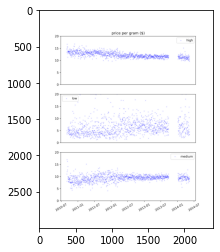

In [12]:
import matplotlib.image as mpimg

img=mpimg.imread('../content/timeseries1.png')
plt.imshow(img)
files.download('../content/timeseries1.png')

In [22]:
RunModels(dailies)

\begin{tabular}{|c|c|c|}
\hline
intercept & slope & $R^2$ \\ \hline
13.450 (0) & -0.708 (3.7e-160) & 0.444 \\
5.362 (3.1e-130) & 0.568 (2.8e-09) & 0.030 \\
8.879 (0) & 0.283 (1.8e-15) & 0.050 \\
\hline
\end{tabular}


In [40]:
PrintSerialCorrelations(dailies)

                  ppg       date     years
2010-09-02  13.384186 2010-09-02  0.000000
2010-09-03  14.459588 2010-09-03  0.002738
2010-09-04  14.923333 2010-09-04  0.005476
2010-09-05  16.667500 2010-09-05  0.008214
2010-09-06  15.537500 2010-09-06  0.010952
before ewm in FillMissing


TypeError: ignored

In [ ]:

MakeAcfPlot(dailies)

name = 'high'
daily = dailies[name]

PlotLinearModel(daily, name)
PlotRollingMean(daily, name)
PlotFilled(daily, name)

years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Save(root='timeseries4',
                title='predictions',
                xlabel='years',
                xlim=xlim,
                ylabel='price per gram ($)',
                formats=FORMATS)

name = 'medium'
daily = dailies[name]

thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotIntervals(daily, years)
PlotPredictions(daily, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Save(root='timeseries5',
                title='predictions',
                xlabel='years',
                xlim=xlim,
                ylabel='price per gram ($)',
                formats=FORMATS)